# Поэтапный разбор соревнования M5 Forecasting - Accuracy

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# функция оптимизирующая место занимаемое набором данных
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
sales_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

In [ ]:
submission = reduce_mem_usage(submission, True)
sales_df = reduce_mem_usage(sales_df, True)
calendar_df = reduce_mem_usage(calendar_df, True)
prices_df = reduce_mem_usage(prices_df, True)

## Разведочный анализ данных

### Первый взгляд на данные.

Древовидная структура данных, из которой видно, что данные собраны по 3 штатам. В каждом штате взято 3-4 магазина.

Так же присутствует 3 категории товаров: еда, хобби, домашнее хозяйство - которые в свою очередь бьются на подкатегории, а те уже на отдельные товары

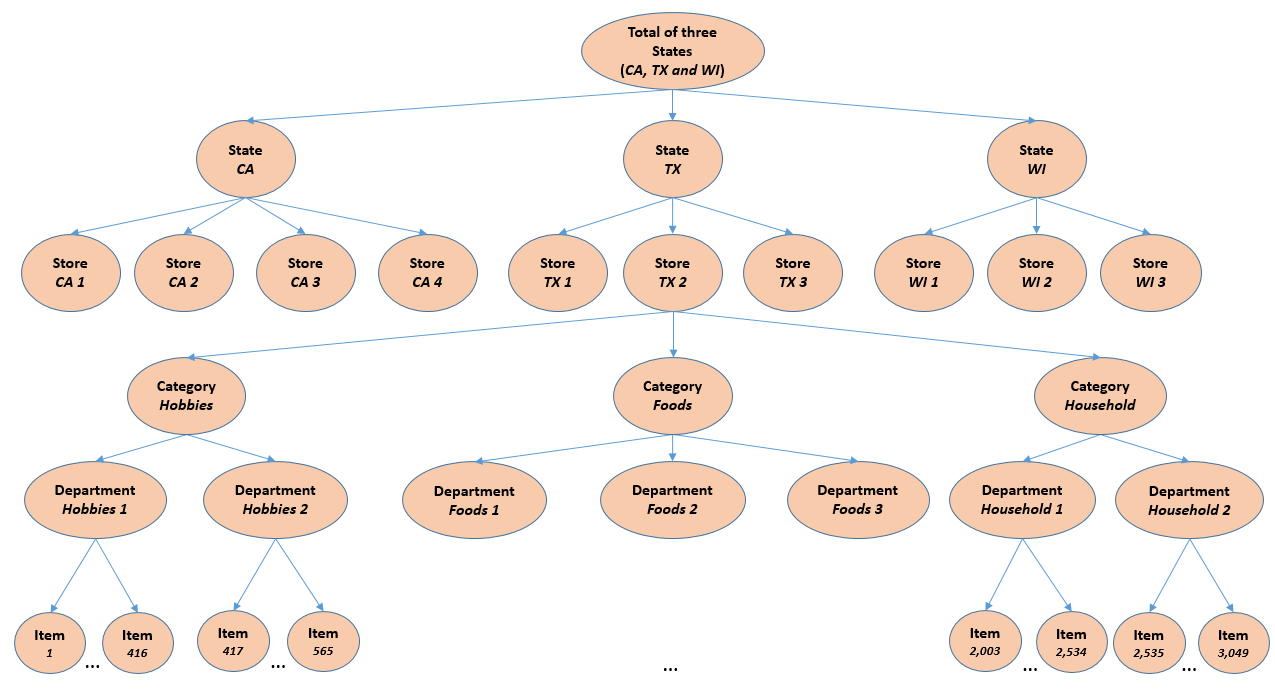

In [ ]:
 f"Shapes of df's: submission - {submission.shape}, sales - {sales_df.shape}, calendar - {calendar_df.shape}, prices - {prices_df.shape}"

Представление ответа

In [ ]:
"""id - HOBBIES_2_004_WI_1 - говорит о том, что это 4 позиция товара 2-й подкатегории товаров категории "Хобби" в 1-м магазине штата WI
validation - значит, что данный id необходимо использовать для предсказаний открытой части соревнования - прогноз с 1914 по 1941 день
evaluation - значит, что данный id необходимо использовать для предсказаний закрытой части соревнования - прогноз с 1942 по 1969 день
F1 - F28 - 28 дней по которым необходимо предсказать количество покупок данного товара """
submission.sample(3)

In [ ]:
submission[submission.id.apply(lambda r: r.endswith('validation'))].shape, \
submission[submission.id.apply(lambda r: r.endswith('evaluation'))].shape, 

Данные по количеству покупок каждого товара за каждый день за исследуемый период

In [ ]:
"""id - обозначает тоже самое, что в submission с той лишь разницей, что тут данные только для открытой части соревнования
item_id - идентификатор товара (FOODS_3_629 - 629 товар 3-й подкатегории категории Еда)
dept_id - идентификатор подкатегории
cat_id - идентификатор категории
store_id - идентификатор магазина
state_id - идентификатор штата
d_1..d_1913 - сведения о количестве товаров купленных по каждому товару за каждый день
"""
sales_df.sample(3)

In [ ]:
sales_df.describe()

In [ ]:
sales_df.info()

Календарь - описывает данные о событиях по каждой дате

In [ ]:
"""date - дата
wm_yr_wk - номер недели
weekday - день недели
wday - номер дня недели
month - номер месяца
year - год
d - номер дня
event_name_1 - имя события, если оно происходило в этот день
event_type_1 - тип события, если оно происходило в этот день
event_name_2 - имя события 2, если оно происходило в этот день
event_type_2 - тип события 2, если оно происходило в этот день
snap_CA, snap_TX, snap_WI - (SNAP - программа помощи в питании) - показывает было ли в этот день по этому штату распределение пособия по питанию
"""
calendar_df.head(5)

In [ ]:
calendar_df.event_name_1.value_counts()

In [ ]:
calendar_df.event_type_1.value_counts()

In [ ]:
calendar_df.event_name_2.value_counts()

In [ ]:
calendar_df.event_type_2.value_counts()

In [ ]:
calendar_df.describe()

In [ ]:
calendar_df.info()

In [ ]:
calendar_df.snap_CA.sum(), calendar_df.snap_TX.sum(), calendar_df.snap_WI.sum(), 

In [ ]:
"""store_id - идентификатор магазина (включает наименование штата)
item_id - идентификатор продукта (включает категорию и подкатегорию товара)
wm_yr_wk - номер недели
sell_price - цена товара в данном магазине на данной неделе
"""
prices_df.sample(5)

In [ ]:
prices_df.describe()

In [ ]:
prices_df.info()

### Анализ таблицы "sales_df"

In [ ]:
sales_df.groupby('state_id').sum().T.plot(subplots=True, figsize=(16, 8))

In [ ]:
sales_df.groupby('store_id').sum().T.plot(subplots=True, figsize=(16, 10))

In [ ]:
sales_df.groupby('cat_id').sum().loc[:,'d_1':'d_51'].T.plot(subplots=False, figsize=(16, 10))

In [ ]:
sales_df['sum_for_peariod'] = sales_df.iloc[:, 6:].sum(axis=1)

In [ ]:
sales_df.groupby('store_id')['sum_for_peariod'].describe()

In [ ]:
# sales_df[]
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].min()]

In [ ]:
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].max()]

In [ ]:
sales_df.groupby('cat_id').sum_for_peariod.sum()

In [ ]:
sales_df.groupby(['cat_id', 'store_id']).sum_for_peariod.agg([min, max, np.mean, np.std])

Используем календарь для анализа данных с учетом различных событий

In [ ]:
sales_df.sample(5)

In [ ]:
calendar_df.sample(3)

In [ ]:
events_days = pd.concat([sales_df.loc[:, :'state_id'],
                         sales_df[calendar_df[:1913][~calendar_df.event_type_1[:1913].isna()].d]],
                       axis = 1)
events_days.sample(5)

In [ ]:
not_events_days = pd.concat([sales_df.loc[:, :'state_id'],
                         sales_df[calendar_df[:1913][(calendar_df.event_type_1[:1913].isna())&(calendar_df.event_type_2[:1913].isna())].d]],
                       axis = 1)
not_events_days.sample(5)

In [ ]:
events_days.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8))

In [ ]:
not_events_days.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=True, figsize=(16, 8))

In [ ]:
events_days.groupby(['store_id', 'cat_id']).sum()

In [ ]:
not_events_days.groupby(['store_id', 'cat_id']).sum() #.T.plot(subplots=True, figsize=(16, 20))

In [ ]:
calendar_df

In [ ]:
snapCA = pd.concat([not_events_days.loc[not_events_days.state_id=='CA', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='CA', calendar_df[:1913][(calendar_df[:1913].snap_CA==1) & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
snapTX = pd.concat([not_events_days.loc[not_events_days.state_id=='TX', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='TX', calendar_df[:1913][(calendar_df[:1913].snap_TX==1)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
snapWI = pd.concat([not_events_days.loc[not_events_days.state_id=='WI', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='WI', calendar_df[:1913][(calendar_df[:1913].snap_WI==1)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapCA = pd.concat([not_events_days.loc[not_events_days.state_id=='CA', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='CA', calendar_df[:1913][(calendar_df[:1913].snap_CA==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapTX = pd.concat([not_events_days.loc[not_events_days.state_id=='TX', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='TX', calendar_df[:1913][(calendar_df[:1913].snap_TX==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapWI = pd.concat([not_events_days.loc[not_events_days.state_id=='WI', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='WI', calendar_df[:1913][(calendar_df[:1913].snap_WI==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)

In [ ]:
snapCA.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8))

In [ ]:
not_snapCA.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8))

Анализ таблицы цен

In [ ]:
prices_df.sample(5)

In [ ]:
one_item = prices_df[prices_df.item_id == 'FOODS_3_133']
for id in one_item.store_id.unique():
    df =  one_item[one_item.store_id==id]
    df.plot.scatter('wm_yr_wk','sell_price', title=id)

In [ ]:
prices_df[(prices_df.item_id == 'HOBBIES_1_001') & (prices_df.store_id == 'TX_1')].wm_yr_wk.values

In [ ]:
sales_df[(sales_df.item_id == 'HOBBIES_1_001') & (sales_df.store_id=='CA_1')].groupby('store_id').sum() #calendar_df.wm_yr_wk == 11353

In [ ]:
sales_df


Далее можно самостоятельно попробовать посмотреть на данные с разных сторон. Вот примеры, на которые можно посмотреть:

https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models

# Собираем все данные вместе и делаем первую модель

In [ ]:
# импортируем библиотеки для работы со временем, очистки от лишних ссылок в памяти, биб
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb

# задаем переменные
pd.options.display.max_columns = 50
# соответствие имен столбцов их типам данных
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

FIRST_DAY = 800 # Если хотите загрузить все данные, то установите '1' -->  Но при этом высокий риск, что не хватит памяти !
h = 28 # количество дней, на которые создается предсказание
max_lags = 366 # основываясь на каком количестве дней мы будем строить предсказание 
tr_last = 1913 # последний день для тренировки
fday = datetime(2016,4, 25) # дата первого дня для предсказания
fday

In [ ]:
# собираем все таблицы в одну
def create_dt(is_train = True, nrows = None, first_day = 1200):
    # таблица цен. Кодируем категориальные признанки в числа типа int
    prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
    # таблица календарь. Кодируем категориальные признанки в числа типа int
    cal = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    # вычисляем день, начиная с которого будем использовать данные
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)] # выбираем числовые данные
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'] # выбираем категориальные данные
    dtype = {numcol:"float32" for numcol in numcols} # задаем тип данных для числовых столбцов
    dtype.update({col: "category" for col in catcols if col != "id"})
    # скачиваем данные о покупках
    dt = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    # кодируем категориальные признаки
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    # если имеем дело с тренировочным набором данных, то задаем пустые дни для предсказания
    if not is_train:
        for day in range(tr_last+1, tr_last+ 2*h +1):
            dt[f"d_{day}"] = np.nan
    # 
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [ ]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")


In [ ]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df = reduce_mem_usage(df)

In [ ]:
%%time

create_fea(df)
df.shape

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.dropna(inplace = True)
df.shape

In [ ]:
df = reduce_mem_usage(df)

In [ ]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [ ]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 1000000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [ ]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1500,
#     'device' : 'gpu'
}

In [ ]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50) 

In [ ]:
%%time

te = create_dt(False)
te.shape

In [ ]:
df = reduce_mem_usage(df)

In [ ]:
%%time

for i in range(0, 28):
    day = fday + timedelta(days=i)
    print(i, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    create_fea(tst)
    tst = tst.loc[tst.date == day , train_cols]
    te.loc[te.date == day, "sales"] = 1.02*m_lgb.predict(tst) # magic multiplier by kyakovlev

In [ ]:
%%time

te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                      "id"].str.replace("validation$", "evaluation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.to_csv("submission.csv",index=False)
te_sub.shape

In [ ]:
te_sub.head(10)